# Graphing and reporting for the black-box optimization exercise

This is an auxiliary notebook that works on the data from the different function, calculates indicator and graphs results.

## Loads and calculations

Load inputs and outputs onto a dataframe

In [ ]:
import pandas as pd
import numpy as np
import re
import ast

# New dataframe
inputs_outputs = pd.DataFrame(columns=['function', 'inputs', 'output', 'week'])

# --------------------------------------------------
# 1. Initial data (week unknown)
# --------------------------------------------------
for X in range(1, 9):
    inputs_path = f"initial_data/function_{X}/initial_inputs.npy"
    outputs_path = f"initial_data/function_{X}/initial_outputs.npy"

    inputs = np.load(inputs_path)
    outputs = np.load(outputs_path)

    for inp, out in zip(inputs, outputs):
        inputs_outputs.loc[len(inputs_outputs)] = {
            'function': X,
            'inputs': inp,
            'output': out,
            'week': 0
        }


# --------------------------------------------------
# 2. Weekly submission data (week known)
# --------------------------------------------------
inputs_path = "submissions/w9_inputs.txt"
outputs_path = "submissions/w9_outputs.txt"

# ---- Parse inputs ----
with open(inputs_path, 'r') as file:
    content = file.read()

raw_sets = re.split(r'\]\s*\[', content.strip())
raw_sets = [s.strip('[]') for s in raw_sets]

all_sets = []
for s in raw_sets:
    arrays_raw = re.findall(r'array\((.*?)\)', s, re.DOTALL)
    instance_set = [np.array(eval(a)) for a in arrays_raw]
    all_sets.append(instance_set)

# --------------------------------------------------
# 3. Load WEEKLY SUBMISSION OUTPUTS
# --------------------------------------------------
with open(outputs_path, 'r') as file:
    for week_idx, line in enumerate(file, start=1):
        content_clean = line.strip().replace('np.float64(', '').replace(')', '')
        float_list = ast.literal_eval(f'[{content_clean}]')
        outputs = np.array(float_list, dtype=np.float64)[0]

        # For each function
        for func_idx in range(8):
            if week_idx - 1 < len(all_sets) and func_idx < len(all_sets[week_idx - 1]):
                inputs_outputs.loc[len(inputs_outputs)] = {
                    'function': func_idx + 1,
                    'inputs': all_sets[week_idx - 1][func_idx],
                    'output': outputs[func_idx],
                    'week': week_idx
                }

# Final cleanup
inputs_outputs.reset_index(drop=True, inplace=True)

del raw_sets, all_sets, inputs_path, outputs_path, float_list
del inputs, outputs, line, out, instance_set, s, week_idx, X
del func_idx, inp, file, content_clean, content, arrays_raw

Add columns with rolling best and flag on weeks with an improvement.

In [2]:
# Ensure correct ordering
inputs_outputs = inputs_outputs.sort_values(
    ['function', 'week']
).reset_index(drop=True)

# --------------------------------------------------
# 1. Compute per-(function, week) max output
# --------------------------------------------------
week_max = (
    inputs_outputs
    .groupby(['function', 'week'], as_index=False)['output']
    .max()
    .rename(columns={'output': 'week_max'})
)

# --------------------------------------------------
# 2. Compute best_so_far per function, week-by-week
# --------------------------------------------------
week_max['best_so_far'] = (
    week_max
    .groupby('function')['week_max']
    .cummax()
)

# --------------------------------------------------
# 3. Compute is_new_best (week-level)
# --------------------------------------------------
week_max['prev_best'] = (
    week_max
    .groupby('function')['best_so_far']
    .shift(1)
)

week_max['is_new_best'] = (
    (week_max['week'] != 0) &
    (week_max['week_max'] > week_max['prev_best'])
)

week_max['is_new_best'] = week_max['is_new_best'].fillna(False)

# --------------------------------------------------
# 4. Merge back to original rows
# --------------------------------------------------
inputs_outputs = inputs_outputs.merge(
    week_max[['function', 'week', 'best_so_far', 'is_new_best']],
    on=['function', 'week'],
    how='left'
)

Add improvement percentages

In [3]:
# --------------------------------------------------
# Best initial value (at week 0) per function
# --------------------------------------------------
week0_best = (
    week_max[week_max['week'] == 0]
    .set_index('function')['week_max']
)

# Map into week_max
week_max['best_week0'] = week_max['function'].map(week0_best)

# --------------------------------------------------
# improvement_pct (week-over-week)
# --------------------------------------------------
week_max['imprv_pct'] = np.where(
    week_max['is_new_best'],
    100.0 * (week_max['week_max'] - week_max['prev_best']) / np.abs(week_max['prev_best']),
    np.nan
)

# --------------------------------------------------
# overall_improvement_pct (vs week 0)
# --------------------------------------------------
week_max['overall_imprv_pct'] = np.where(
    week_max['is_new_best'],
    100.0 * (week_max['week_max'] - week_max['best_week0']) / np.abs(week_max['best_week0']),
    np.nan
)

# --------------------------------------------------
# Merge back to row-level dataframe
# --------------------------------------------------
# Select only the columns to merge from week_max
week_max_merge = week_max[
    ['function', 'week', 'imprv_pct', 'overall_imprv_pct']
]

# Merge into inputs_outputs
inputs_outputs = inputs_outputs.merge(
    week_max_merge,
    on=['function', 'week'],
    how='left'
)

In [4]:
del week0_best, week_max, week_max_merge

## Recap tables

Overall table

In [5]:
# Prepare an empty summary dataframe
summary_rows = []

for func, g in inputs_outputs.groupby('function'):
    # Baseline best (week 0)
    baseline_best = g.loc[g['week'] == 0, 'best_so_far'].iloc[0]
    
    # Best value overall
    best_value = g['best_so_far'].max()
    
    # Number of samples improved
    n_improved = int(g['is_new_best'].sum())
    
    # % improvement: take overall_improvement_pct from latest week with is_new_best=True
    improved_rows = g[g['is_new_best']]
    if not improved_rows.empty:
        latest_row = improved_rows.loc[improved_rows['week'].idxmax()]
        pct_imprv = latest_row['overall_imprv_pct']
    else:
        pct_imprv = 0.0  # or np.nan if preferred
    
    summary_rows.append({
        'Function': func,
        'Baseline Best': baseline_best,
        'Best Value': best_value,
        '% Improvement': pct_imprv,
        '# Samples improved': int(n_improved)
    })

# Convert to dataframe
summary_df = pd.DataFrame(summary_rows)

# Generate GitHub Markdown table
md_table = '| Function | Baseline Best | Best Value | % Improvement | # Samples improved |\n'
md_table += '|----------|--------------|-----------|---------------|------------------|\n'

for _, row in summary_df.iterrows():
    md_table += (
        f"| {row['Function']} "
        f"| {row['Baseline Best']:.4f} "
        f"| {row['Best Value']:.4f} "
        f"| {row['% Improvement']:,.2f}% "
        f"| {int(row['# Samples improved'])} |\n"
    )

print(md_table)

del summary_rows, func, g, baseline_best, improved_rows
del latest_row, best_value, n_improved, pct_imprv, row

| Function | Baseline Best | Best Value | % Improvement | # Samples improved |
|----------|--------------|-----------|---------------|------------------|
| 1.0 | 0.0000 | 0.0000 | 346,949,883.15% | 1 |
| 2.0 | 0.6112 | 0.6670 | 9.13% | 1 |
| 3.0 | -0.0348 | -0.0015 | 95.71% | 1 |
| 4.0 | -4.0255 | 0.6402 | 115.90% | 3 |
| 5.0 | 1088.8596 | 8662.4825 | 695.56% | 3 |
| 6.0 | -0.7143 | -0.4072 | 42.99% | 1 |
| 7.0 | 1.3650 | 1.7459 | 27.91% | 3 |
| 8.0 | 9.5985 | 9.9659 | 3.83% | 4 |



Which renders (manual copy-paste):

| Function | Baseline Best | Best Value | % Improvement | # Samples improved |
|----------|--------------|-----------|---------------|------------------|
| 1 | 0.0000 | 0.0000 | 346949883.15% | 1 |
| 2 | 0.6112 | 0.6670 | 9.13% | 1 |
| 3 | -0.0348 | -0.0015 | 95.71% | 1 |
| 4 | -4.0255 | 0.6402 | 115.90% | 3 |
| 5 | 1088.8596 | 8662.4825 | 695.56% | 3 |
| 6 | -0.7143 | -0.4072 | 42.99% | 1 |
| 7 | 1.3650 | 1.7459 | 27.91% | 3 |
| 8 | 9.5985 | 9.9659 | 3.83% | 4 |

## Graphs

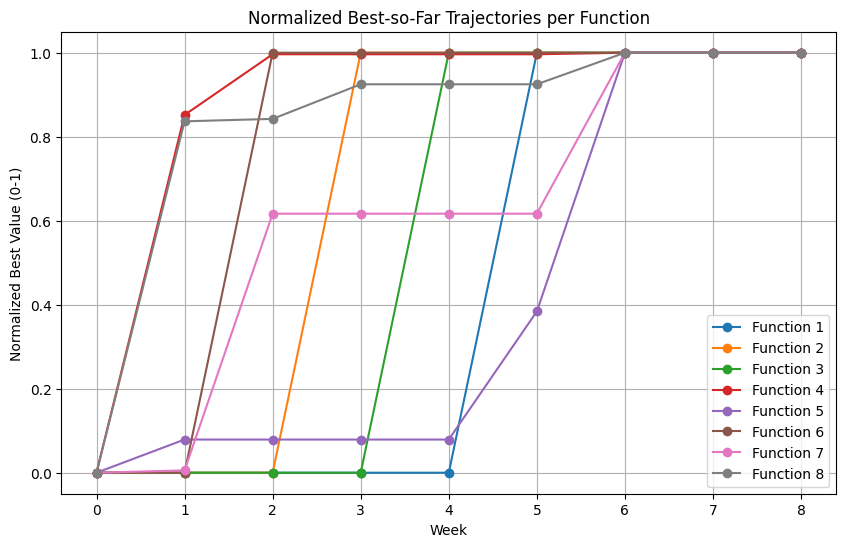

In [6]:
import matplotlib.pyplot as plt

# Aggregate max best_so_far per function per week
best_weekly = inputs_outputs.groupby(['function', 'week'], as_index=False)['best_so_far'].max()

plt.figure(figsize=(10,6))
for func in best_weekly['function'].unique():
    func_data = best_weekly[best_weekly['function'] == func].copy()
    # Normalize best_so_far for the function
    min_val = func_data['best_so_far'].min()
    max_val = func_data['best_so_far'].max()
    func_data['best_normalized'] = (func_data['best_so_far'] - min_val) / (max_val - min_val + 1e-12)
    
    plt.plot(func_data['week'], func_data['best_normalized'], marker='o', label=f'Function {func}')

plt.xlabel('Week')
plt.ylabel('Normalized Best Value (0-1)')
plt.title('Normalized Best-so-Far Trajectories per Function')
plt.legend()
plt.grid(True)
plt.show()


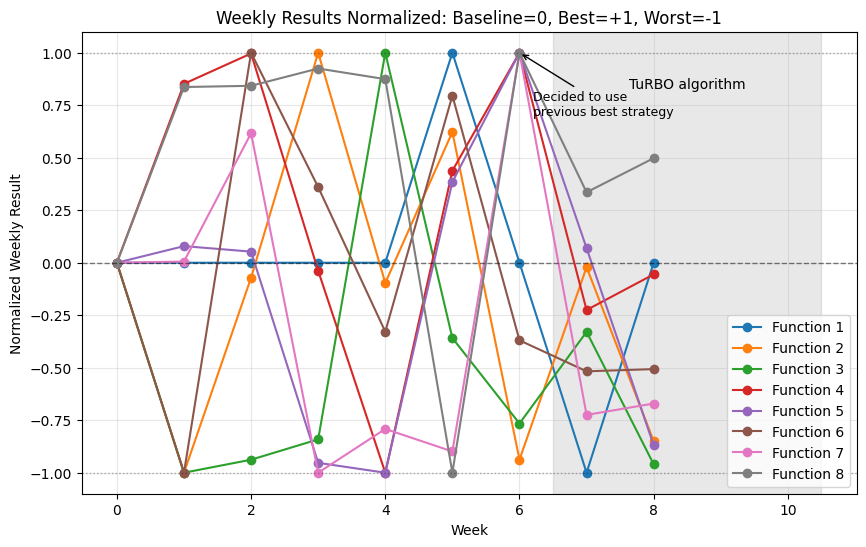

In [7]:
# --------------------------------------------------
# Compute per-(function, week) values
# --------------------------------------------------
rows = []

for func, g in inputs_outputs.groupby('function'):
    
    # 1. First, calculate the value for every week 
    #    (Calculate the points we intend to plot)
    weekly_data = []
    
    # Get the baseline (Week 0)
    baseline_val = g.loc[g['week'] == 0, 'best_so_far'].max()
    
    for week, gw in g.groupby('week'):
        if week == 0:
            val = baseline_val
        else:
            # The value for the week is the max output found in that week
            val = gw['output'].max()
            
        weekly_data.append({'week': week, 'val': val})
        
    # Convert to DataFrame to easily find min/max of the *plotted* points
    func_df = pd.DataFrame(weekly_data)
    
    # 2. Define bounds based on the AGGREGATED weekly data
    #    This guarantees the plot touches +1 and -1 exactly.
    
    # Fix 1: Best is the max of the weekly maxes (which is the function max)
    best_ref = func_df['val'].max()
    
    # Fix 2: Worst is the min of the weekly maxes (ensuring the lowest point is -1)
    worst_ref = func_df['val'].min()
    
    baseline_ref = baseline_val

    # 3. Normalize using these consistent bounds
    for item in weekly_data:
        val = item['val']
        week = item['week']
        
        if val >= baseline_ref:
            denom = best_ref - baseline_ref
            # Avoid division by zero if flat
            norm_val = (val - baseline_ref) / denom if denom != 0 else 0.0
        else:
            denom = baseline_ref - worst_ref
            # Avoid division by zero if flat
            norm_val = -(baseline_ref - val) / denom if denom != 0 else 0.0
            
        rows.append({
            'function': func,
            'week': week,
            'value_norm': norm_val
        })

plot_df = pd.DataFrame(rows)

# --------------------------------------------------
# Plot
# --------------------------------------------------
plt.figure(figsize=(10, 6))

for func in plot_df['function'].unique():
    fdata = plot_df[plot_df['function'] == func]
    plt.plot(
        fdata['week'], 
        fdata['value_norm'], 
        marker='o', 
        label=f'Function {func}'
    )

# Visual aids (same as before)
plt.annotate('Decided to use\nprevious best strategy', xy=(6, 1), xytext=(6.2, 0.7),
             arrowprops=dict(arrowstyle='->', lw=1), fontsize=9, ha='left')

plt.axvspan(6.5, 10.5, alpha=0.18, color='gray')
plt.text(8.5, 0.85, 'TuRBO algorithm', ha='center', va='center', fontsize=10)

plt.axhline(0, linestyle='--', linewidth=1, color='k', alpha=0.5)
plt.axhline(1, linestyle=':', linewidth=1, color='k', alpha=0.3)
plt.axhline(-1, linestyle=':', linewidth=1, color='k', alpha=0.3)

plt.xlabel('Week')
plt.ylabel('Normalized Weekly Result')
plt.title('Weekly Results Normalized: Baseline=0, Best=+1, Worst=-1')
plt.legend()
plt.grid(True, alpha=0.3)


# EXPORT
import os
os.makedirs('images', exist_ok=True)
plt.savefig('images/all_functions_normalized.png', bbox_inches='tight', dpi=300)

plt.show()

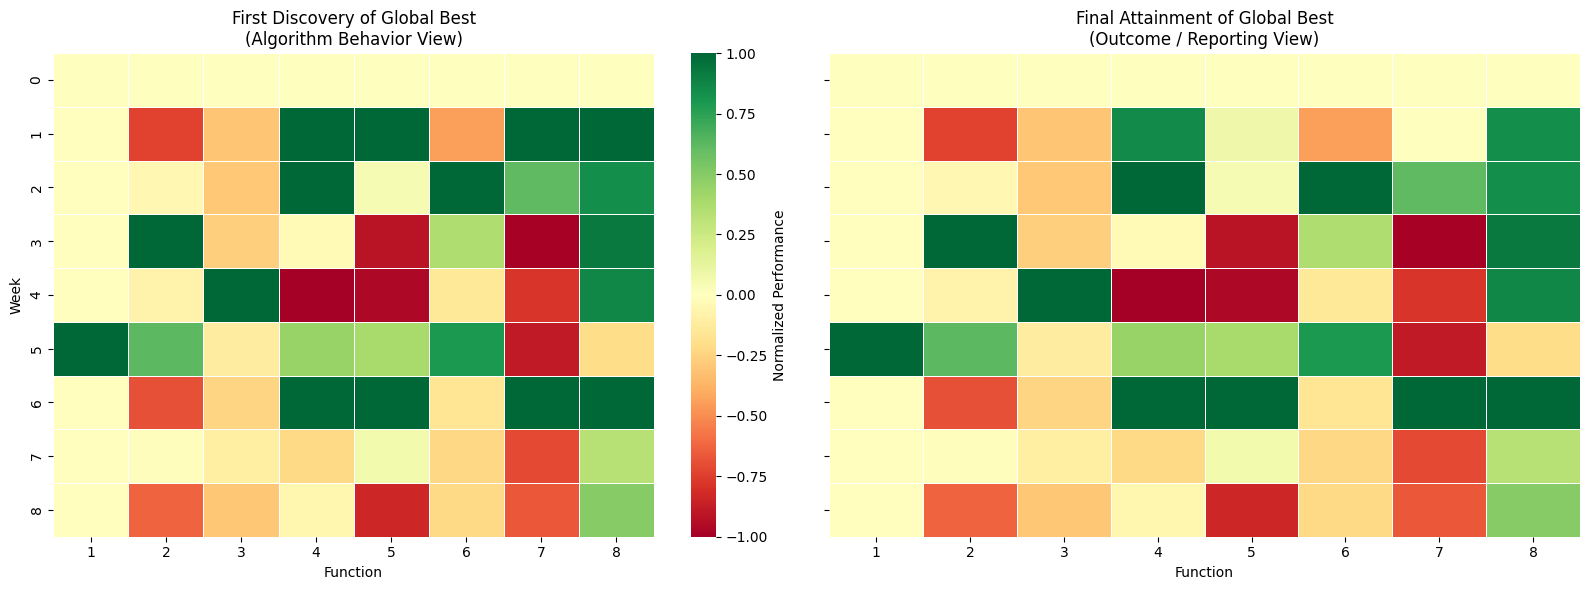

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def build_heatmap_df(inputs_outputs, best_mode="first"):
    rows = []

    for func, g in inputs_outputs.groupby('function'):

        baseline = g.loc[g['week'] == 0, 'best_so_far'].max()
        global_best = g['best_so_far'].max()
        global_worst = g['output'].min()

        # 🔑 use is_new_best to identify true improvement weeks
        improvement_weeks = g.loc[g['is_new_best'], 'week']

        if improvement_weeks.empty:
            best_week = None
        elif best_mode == "first":
            best_week = improvement_weeks.min()
        elif best_mode == "last":
            best_week = improvement_weeks.max()
        else:
            raise ValueError("best_mode must be 'first' or 'last'")

        all_weeks = range(g['week'].min(), g['week'].max() + 1)

        for week in all_weeks:
            gw = g[g['week'] == week]
            if gw.empty:
                continue

            val = baseline if week == 0 else gw['output'].max()

            # ✅ Assign +1 ONLY at true improvement week
            if best_week is not None and week == best_week:
                norm_val = 1.0
            elif val >= baseline:
                denom = global_best - baseline
                norm_val = (val - baseline) / denom if denom != 0 else 0.0
            else:
                denom = baseline - global_worst
                norm_val = -(baseline - val) / denom if denom != 0 else 0.0

            rows.append({
                'function': func,
                'week': week,
                'value_norm': norm_val
            })

    df = pd.DataFrame(rows)
    return df.pivot(index='week', columns='function', values='value_norm').sort_index()


# --------------------------------------------------
# Build both heatmaps
# --------------------------------------------------
heatmap_first = build_heatmap_df(inputs_outputs, best_mode="first")
heatmap_last = build_heatmap_df(inputs_outputs, best_mode="last")

# --------------------------------------------------
# Plot side-by-side
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.heatmap(
    heatmap_first,
    ax=axes[0],
    cmap='RdYlGn',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'Normalized Performance'}
)
axes[0].set_title(
    'First Discovery of Global Best\n'
    '(Algorithm Behavior View)'
)
axes[0].set_xlabel('Function')
axes[0].set_ylabel('Week')


sns.heatmap(
    heatmap_last,
    ax=axes[1],
    cmap='RdYlGn',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar=False
)
axes[1].set_title(
    'Final Attainment of Global Best\n'
    '(Outcome / Reporting View)'
)
axes[1].set_xlabel('Function')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


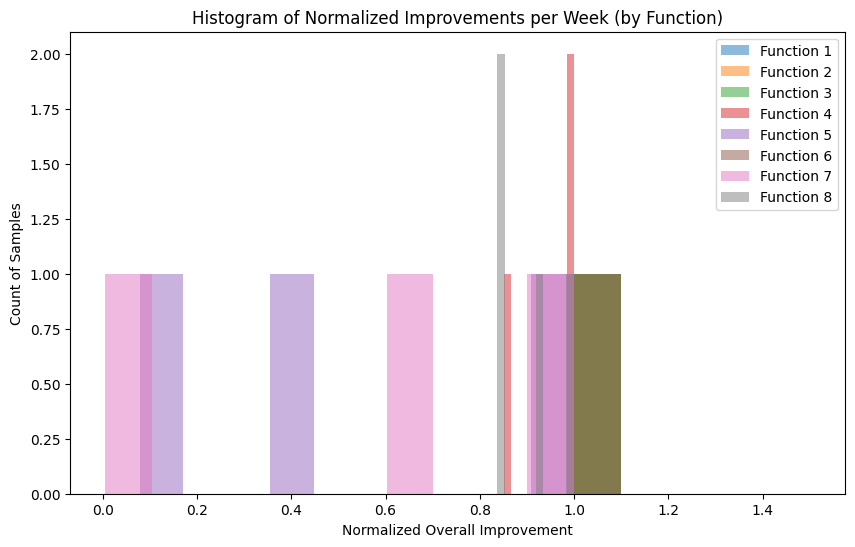

In [ ]:
plt.figure(figsize=(10,6))

for func, g in inputs_outputs.groupby('function'):
    # Take only improved samples
    improved = g[g['is_new_best']]['overall_imprv_pct']
    # Normalize for comparison
    improved_norm = improved / (improved.abs().max() + 1e-12)
    plt.hist(improved_norm, bins=10, alpha=0.5, label=f'Function {func}')

plt.xlabel('Normalized Overall Improvement')
plt.ylabel('Count of Samples')
plt.title('Histogram of Normalized Improvements per Week (by Function)')
plt.legend()
plt.show()
